In [ ]:
! pip install kaggle

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
! mkdir ~/.kaggle

In [ ]:
!cp /content/drive/MyDrive/ColabNotebooks/kaggle_API_credentials/kaggle.json ~/.kaggle/kaggle.json

In [ ]:
! chmod 600 ~/.kaggle/kaggle.json


In [ ]:
! kaggle competitions download -c walmart-recruiting-store-sales-forecasting


  0% 0.00/2.70M [00:00<?, ?B/s]
100% 2.70M/2.70M [00:00<00:00, 502MB/s]


In [ ]:
! unzip walmart-recruiting-store-sales-forecasting
! unzip train.csv.zip
! unzip test.csv.zip
! unzip features.csv.zip

Archive:  walmart-recruiting-store-sales-forecasting.zip
  inflating: features.csv.zip        
  inflating: sampleSubmission.csv.zip  
  inflating: stores.csv              
  inflating: test.csv.zip            
  inflating: train.csv.zip           
Archive:  train.csv.zip
  inflating: train.csv               
Archive:  test.csv.zip
  inflating: test.csv                
Archive:  features.csv.zip
  inflating: features.csv            


In [ ]:
import pandas as pd
import numpy as np
from prophet import Prophet
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt

# Suppress Prophet's informational messages
import logging
logging.getLogger('cmdstanpy').setLevel(logging.WARNING)

print("Libraries imported successfully.")

Libraries imported successfully.


In [ ]:
# Load the datasets
try:
    train_df = pd.read_csv('train.csv.zip')
    features_df = pd.read_csv('features.csv.zip')
    stores_df = pd.read_csv('stores.csv')
    print("Data loaded successfully.")
except FileNotFoundError:
    print("Make sure train.csv.zip, features.csv.zip, and stores.csv are in the same directory.")
    # Handle file not found error

# --- FIX IS HERE ---
# Convert 'Date' columns to datetime objects immediately after loading.
# This ensures data types are consistent for merging.
train_df['Date'] = pd.to_datetime(train_df['Date'])
features_df['Date'] = pd.to_datetime(features_df['Date'])

print("\nData types for 'Date' columns after conversion:")
print(f"train_df['Date']: {train_df.dtypes['Date']}")
print(f"features_df['Date']: {features_df.dtypes['Date']}")

Data loaded successfully.

Data types for 'Date' columns after conversion:
train_df['Date']: datetime64[ns]
features_df['Date']: datetime64[ns]


# Preprocessing

In [ ]:
class WalmartDataPreprocessor(BaseEstimator, TransformerMixin):
    """
    A custom transformer for the Walmart dataset. It:
    1. Merges train, features, and stores data.
    2. Filters for a specific Store and Department.
    3. Fills missing values in feature columns.
    4. Renames columns to Prophet's required format ('ds', 'y').
    5. Selects columns to be used as regressors.
    """
    def __init__(self, store_id, dept_id, extra_regressors=None):
        self.store_id = store_id
        self.dept_id = dept_id
        self.extra_regressors = extra_regressors if extra_regressors is not None else []

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        df = X.merge(stores_df, on='Store', how='left')
        df = df.merge(features_df, on=['Store', 'Date', 'IsHoliday'], how='left')

        df_filtered = df[(df['Store'] == self.store_id) & (df['Dept'] == self.dept_id)].copy()

        df_filtered.rename(columns={'Date': 'ds', 'Weekly_Sales': 'y'}, inplace=True)
        # We already converted 'Date' to datetime, but if this preprocessor were used
        # on raw data, this line would be essential.
        df_filtered['ds'] = pd.to_datetime(df_filtered['ds'])

        # --- FIX FOR FUTUREWARNING IS HERE ---
        # Handle missing values in regressors using direct assignment instead of inplace on a chain.
        for regressor in self.extra_regressors:
            if regressor in df_filtered.columns:
                df_filtered[regressor] = df_filtered[regressor].fillna(0)

        final_cols = ['ds'] + self.extra_regressors
        if 'y' in df_filtered.columns:
            final_cols.append('y')

        return df_filtered[final_cols]

In [ ]:
class ProphetWrapper(BaseEstimator, TransformerMixin):
    """
    A scikit-learn compatible wrapper for the Prophet model.
    It allows Prophet to be used as a step in a Pipeline.
    """
    def __init__(self, holidays=None, extra_regressors=None, **prophet_kwargs):
        self.holidays = holidays
        self.extra_regressors = extra_regressors if extra_regressors is not None else []
        self.prophet_kwargs = prophet_kwargs
        self.model = None

    def fit(self, X, y=None):
        # X is the preprocessed DataFrame with 'ds', 'y', and regressor columns
        self.model = Prophet(holidays=self.holidays, **self.prophet_kwargs)

        # Add extra regressors to the model
        for regressor in self.extra_regressors:
            if regressor in X.columns:
                self.model.add_regressor(regressor)

        # Fit the model
        self.model.fit(X)
        return self

    def predict(self, X):
        # X is the future dataframe for which we want predictions.
        # It must contain 'ds' and the regressor columns.
        if self.model is None:
            raise RuntimeError("You must fit the model before making predictions.")

        # Prophet's predict method requires a dataframe with 'ds' and regressor columns
        forecast = self.model.predict(X)

        # Return only the 'yhat' (prediction) column
        return forecast['yhat'].values

In [ ]:
# Define which features we want to use as extra regressors
# These must be present in the features_df
EXTRA_REGRESSORS = ['Temperature', 'Fuel_Price', 'CPI', 'Unemployment']

# Create the special holidays dataframe for Prophet
# Prophet gets better results if you explicitly tell it about holidays
holiday_dates = features_df[features_df['IsHoliday'] == True]['Date'].unique()
holidays_df = pd.DataFrame({
    'holiday': 'WalmartHoliday',
    'ds': pd.to_datetime(holiday_dates),
    'lower_window': -3,  # Include days before the holiday
    'upper_window': 3,   # Include days after the holiday
})

# Create the full pipeline
prophet_pipeline = Pipeline([
    ('preprocessor', WalmartDataPreprocessor(store_id=1, dept_id=1, extra_regressors=EXTRA_REGRESSORS)),
    ('model', ProphetWrapper(holidays=holidays_df, extra_regressors=EXTRA_REGRESSORS, yearly_seasonality=True, weekly_seasonality=True))
])

print("Pipeline created successfully.")
print(prophet_pipeline)

Pipeline created successfully.
Pipeline(steps=[('preprocessor',
                 WalmartDataPreprocessor(dept_id=1,
                                         extra_regressors=['Temperature',
                                                           'Fuel_Price', 'CPI',
                                                           'Unemployment'],
                                         store_id=1)),
                ('model',
                 ProphetWrapper(extra_regressors=['Temperature', 'Fuel_Price',
                                                  'CPI', 'Unemployment'],
                                holidays=           holiday         ds  lower_window  upper_window
0   WalmartHoliday 2010-02-12            -3             3
1   WalmartHoliday 2010-09-10            -3             3
2   WalmartHoliday 2010-11-26            -3             3
3   WalmartHoliday 2010-12-31            -3             3
4   WalmartHoliday 2011-02-11            -3             3
5   WalmartHoliday 2011-09-09  

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Training the pipeline...


DEBUG:cmdstanpy:input tempfile: /tmp/tmpn5gp9lzw/x1mixnou.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpn5gp9lzw/5owndmnl.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=17841', 'data', 'file=/tmp/tmpn5gp9lzw/x1mixnou.json', 'init=/tmp/tmpn5gp9lzw/5owndmnl.json', 'output', 'file=/tmp/tmpn5gp9lzw/prophet_modely1sz8hp9/prophet_model-20250708172734.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:27:34 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:27:35 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an erro

Training complete.
Making predictions on the validation set...
Prediction complete.

Validation MAE for Store 1, Dept 1: 2737.78
Shape of actuals: (13,)
Shape of predictions: (13,)
Shape of is_holiday_validation: (13,)
Validation WMAE for Store 1, Dept 1: 2155.38


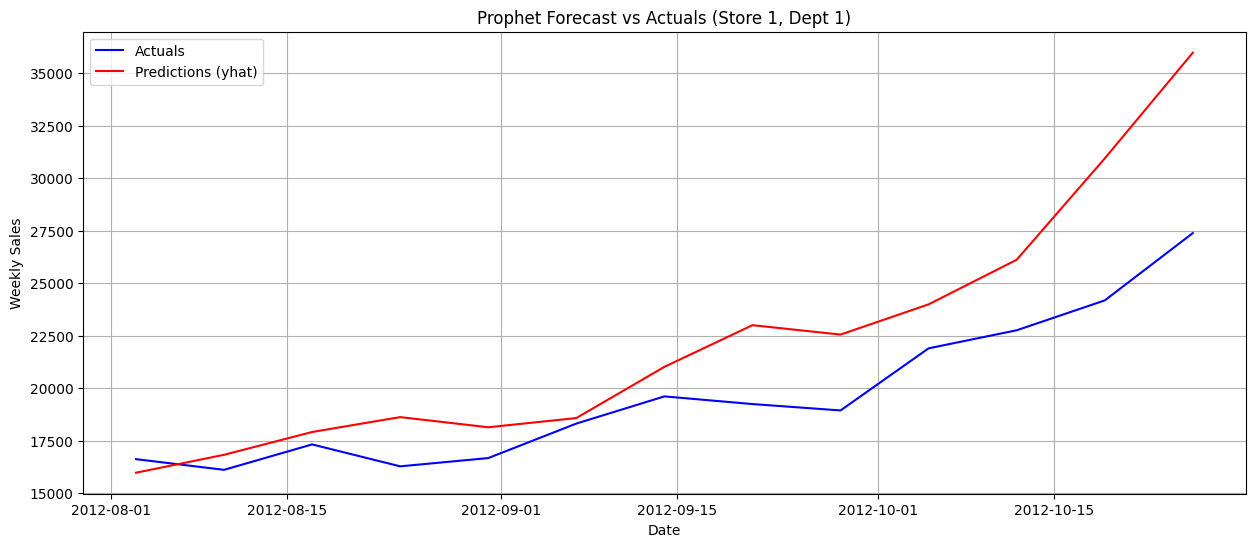

In [ ]:
# Split data into a training and validation set based on date
# The competition test set starts from 2012-11-02, so we'll use a similar cutoff
validation_cutoff_date = '2012-08-01'

# The pipeline expects the raw dataframe as input
train_data_raw = train_df[train_df['Date'] < validation_cutoff_date]
validation_data_raw = train_df[train_df['Date'] >= validation_cutoff_date]

# --- Train the pipeline ---
print("Training the pipeline...")
# The pipeline handles all preprocessing internally
prophet_pipeline.fit(train_data_raw)
print("Training complete.")

# --- Make predictions on the validation set ---
print("Making predictions on the validation set...")
# The pipeline also handles preprocessing for the validation data
predictions = prophet_pipeline.predict(validation_data_raw)
print("Prediction complete.")

# --- Evaluate the predictions ---

# First, we need the actual 'y' values from the validation set
# We can get them by running only the preprocessing step on the validation data
preprocessor_step = prophet_pipeline.named_steps['preprocessor']
validation_processed = preprocessor_step.transform(validation_data_raw)
actuals = validation_processed['y'].values

# Calculate Mean Absolute Error
mae = mean_absolute_error(actuals, predictions)
print(f"\nValidation MAE for Store 1, Dept 1: {mae:.2f}")

# --- FIX IS HERE ---
# The competition uses Weighted Mean Absolute Error (WMAE)

# 1. Create a unique lookup table for holidays from the features dataframe.
#    This prevents the merge from creating duplicate rows.
holiday_lookup = features_df[['Date', 'IsHoliday']].drop_duplicates()

# 2. Merge the processed validation data with the unique holiday lookup table.
is_holiday_validation = validation_processed.merge(holiday_lookup, left_on='ds', right_on='Date')['IsHoliday']

# Check the shapes to confirm they now match
print(f"Shape of actuals: {actuals.shape}")
print(f"Shape of predictions: {predictions.shape}")
print(f"Shape of is_holiday_validation: {is_holiday_validation.shape}")

# 3. Calculate WMAE with the correctly shaped arrays
weights = np.where(is_holiday_validation, 5, 1)
wmae = np.sum(weights * np.abs(actuals - predictions)) / np.sum(weights)
print(f"Validation WMAE for Store 1, Dept 1: {wmae:.2f}")

# --- Visualize the results ---
fig, ax = plt.subplots(figsize=(15, 6))
ax.plot(validation_processed['ds'], actuals, 'b-', label='Actuals')
ax.plot(validation_processed['ds'], predictions, 'r-', label='Predictions (yhat)')
ax.set_title('Prophet Forecast vs Actuals (Store 1, Dept 1)')
ax.set_xlabel('Date')
ax.set_ylabel('Weekly Sales')
ax.legend()
plt.grid(True)
plt.show()

In [ ]:
! unzip train.csv.zip

Archive:  train.csv.zip
  inflating: train.csv               


In [ ]:
! unzip features.csv.zip


Archive:  features.csv.zip
  inflating: features.csv            


In [ ]:
!pip install prophet


In [ ]:
!pip install mlflow dagshub
import mlflow
import dagshub

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.7/24.7 MB 70.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 63.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 261.0/261.0 kB 16.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.7/242.7 kB 14.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 147.8/147.8 kB 10.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.9/114.9 kB 8.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.0/85.0 kB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.9/139.9 kB 9.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 93.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 733.8/733.8 kB 39.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 203.4/203.4 kB 13.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.9/50.9 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 

In [ ]:
dagshub.init(repo_owner='mr-master-afk', repo_name='scaling-meme', mlflow=True)


❗❗❗ AUTHORIZATION REQUIRED ❗❗❗

Output()



Open the following link in your browser to authorize the client:
https://dagshub.com/login/oauth/authorize?state=ae124523-dbf4-4454-a9a4-3fe2829fed55&client_id=32b60ba385aa7cecf24046d8195a71c07dd345d9657977863b52e7748e0f0f28&middleman_request_id=eea4b3ff01cf2875b13e951ddb10f7844c7ab31b520f811b6a2c0e62222119c7




Accessing as mr-master-afk

Initialized MLflow to track repo "mr-master-afk/scaling-meme"

Repository mr-master-afk/scaling-meme initialized!

In [ ]:
experiment_name = "Prophet"
run_name = "Prophet_Cleaning"

In [ ]:
import pandas as pd
from prophet import Prophet # Changed from fbprophet
from sklearn.model_selection import TimeSeriesSplit
import numpy as np
from tqdm import tqdm

# STEP 1: Load data
train = pd.read_csv('/content/train.csv')
test = pd.read_csv('/content/test.csv')
features = pd.read_csv('/content/features.csv')
stores = pd.read_csv('/content/stores.csv')

# STEP 2: Merge datasets
def prepare_data(df):
    df = df.merge(features, on=['Store', 'Date'], how='left')
    df = df.merge(stores, on='Store', how='left')
    df['Date'] = pd.to_datetime(df['Date'])
    return df

train = prepare_data(train)
test = prepare_data(test)

# Remove negative sales
train = train[train['Weekly_Sales'] >= 0]

In [ ]:
mlflow.set_experiment(experiment_name)
with mlflow.start_run(run_name="data_cleaning"):
    # Log basic cleaning stats
    mlflow.log_param("initial_train_rows", len(pd.read_csv('/content/train.csv')))
    mlflow.log_param("train_rows_after_merge", len(train))
    mlflow.log_param("test_rows_after_merge", len(test))

    # Log removed negatives
    negative_sales = (pd.read_csv('/content/train.csv')['Weekly_Sales'] < 0).sum()
    mlflow.log_metric("negative_sales_removed", negative_sales)

    # Log number of missing values after merge
    mlflow.log_metric("train_missing_values", train.isnull().sum().sum())
    mlflow.log_metric("test_missing_values", test.isnull().sum().sum())
mlflow.end_run()


2025/07/08 12:58:49 INFO mlflow.tracking.fluent: Experiment with name 'Prophet' does not exist. Creating a new experiment.


🏃 View run data_cleaning at: https://dagshub.com/mr-master-afk/scaling-meme.mlflow/#/experiments/1/runs/7df68d6149864c04922343f6720225d5
🧪 View experiment at: https://dagshub.com/mr-master-afk/scaling-meme.mlflow/#/experiments/1


# Final model

In [ ]:
import os
import joblib
mlflow.set_experiment("Prophet")
with mlflow.start_run(run_name="Prophet_model"):
    # Log WMAE score
    mlflow.log_metric("wmae", wmae)

    # Log model parameters
    mlflow.log_param("store_id", 1
    mlflow.log_param("extra_regressors",['Temperature','Fuel_Price', 'CPI','Unemployment'])
    # Save model to local file
    os.makedirs("models", exist_ok=True)
    joblib.dump(prophet_pipeline, "models/prophet_model.pkl")

    # Log model as an artifact (this works with DagsHub)
    mlflow.log_artifact("models/prophet_model.pkl", artifact_path="model")

    print("✅ Model logged as artifact to MLflow (DagsHub compatible)")

✅ Model logged as artifact to MLflow (DagsHub compatible)
🏃 View run Prophet_model at: https://dagshub.com/mr-master-afk/scaling-meme.mlflow/#/experiments/1/runs/f675a30e4ef94db2b2a052cf4255600c
🧪 View experiment at: https://dagshub.com/mr-master-afk/scaling-meme.mlflow/#/experiments/1


In [ ]:
import pandas as pd
from prophet import Prophet # Changed from fbprophet
from sklearn.model_selection import TimeSeriesSplit
import numpy as np
from tqdm import tqdm

# STEP 1: Load data
train = pd.read_csv('/content/train.csv')
test = pd.read_csv('/content/test.csv')
features = pd.read_csv('/content/features.csv')
stores = pd.read_csv('/content/stores.csv')

# STEP 2: Merge datasets
def prepare_data(df):
    df = df.merge(features, on=['Store', 'Date'], how='left')
    df = df.merge(stores, on='Store', how='left')
    df['Date'] = pd.to_datetime(df['Date'])
    return df

train = prepare_data(train)
test = prepare_data(test)

# Remove negative sales
train = train[train['Weekly_Sales'] >= 0]

# STEP 3: Create submission template
submission = pd.DataFrame()
# Convert Date to string before concatenation
submission['Id'] = test['Store'].astype(str) + '_' + test['Dept'].astype(str) + '_' + test['Date'].dt.strftime('%Y-%m-%d')
submission['Weekly_Sales'] = 0.0

# STEP 4: Prophet Forecast per (Store, Dept)
group_cols = ['Store', 'Dept']
train_groups = train.groupby(group_cols)
test_groups = test.groupby(group_cols)

# Placeholder for error tracking
errors = []

# Iterate over each group
for (store, dept), train_group in tqdm(train_groups, desc="Running Prophet per group"):

    # Check if this group is in the test set
    if (store, dept) not in test_groups.groups:
        continue

    test_group = test_groups.get_group((store, dept))

    # Prepare data for Prophet
    df = train_group[['Date', 'Weekly_Sales']].rename(columns={'Date': 'ds', 'Weekly_Sales': 'y'})
    df = df.sort_values('ds')

    # Skip small groups
    if len(df) < 20:
        continue

    # Train model
    try:
        model = Prophet(daily_seasonality=False, yearly_seasonality=True, weekly_seasonality=True)
        model.fit(df)

        # Create future dataframe with dates from test set
        future = test_group[['Date']].rename(columns={'Date': 'ds'}).drop_duplicates()
        forecast = model.predict(future)

        # Fill in submission
        forecast = forecast[['ds', 'yhat']]
        merged = test_group[['Store', 'Dept', 'Date']].merge(forecast, left_on='Date', right_on='ds', how='left')
        # Convert Date to string before concatenation
        merged['Id'] = merged['Store'].astype(str) + '_' + merged['Dept'].astype(str) + '_' + merged['Date'].dt.strftime('%Y-%m-%d')
        submission.loc[submission['Id'].isin(merged['Id']), 'Weekly_Sales'] = merged['yhat'].values

    except Exception as e:
        errors.append((store, dept, str(e)))
        continue

# STEP 5: Final submission file
submission.to_csv('/content/prophet_submission.csv', index=False)
print("✅ Submission file saved as prophet_submission.csv")

Streaming output truncated to the last 5000 lines.
12:24:52 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
Running Prophet per group:  82%|████████▏ | 2712/3323 [10:21<02:15,  4.50it/s]DEBUG:cmdstanpy:input tempfile: /tmp/tmp3bvc4ivb/prux66sr.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp3bvc4ivb/8tlf88u_.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=39481', 'data', 'file=/tmp/tmp3bvc4ivb/prux66sr.json', 'init=/tmp/tmp3bvc4ivb/8tlf88u_.json', 'output', 'file=/tmp/tmp3bvc4ivb/prophet_modelm2majys5/prophet_model-20250707122452.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
12:24:52 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
12:24:52 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
Running Prophet 

✅ Submission file saved as prophet_submission.csv
